In [1]:
from simple_model.SimpleModel import cols, SimpleModel
import simple_model.GenerateSimpleModelData as gsm
import torch
import pyro.distributions as dist
import pandas as pd
import pyro
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [7]:
def generate_policy_heatmap(filename):
    model = SimpleModel()
    model.load_state_dict(torch.load(filename))
    model.eval()
    with torch.no_grad():
        df = pd.DataFrame()
        for i in range(50,90):
            for j in range(70,150):
                probs = [model.policy(torch.tensor([i, j]).float())[0].numpy().item(0), 
                        model.policy(torch.tensor([i, j]).float())[1].numpy().item(0)]
                prob_action = np.exp(probs[1])/(np.exp(probs[0]) + np.exp(probs[1]))
                df = df.append({'s_1': i, 's_2': j, 'prob-action': prob_action}, ignore_index=True)
        logit_probs = df.pivot("s_2", "s_1", "prob-action").sort_index(ascending=False)
        fig, (ax1, ax2) = plt.subplots(2,1, figsize=(15,15))
        sns.heatmap(logit_probs, vmax=0.50, ax=ax1)
        sns.heatmap(logit_probs, ax=ax2)
        plt.show()
    return df

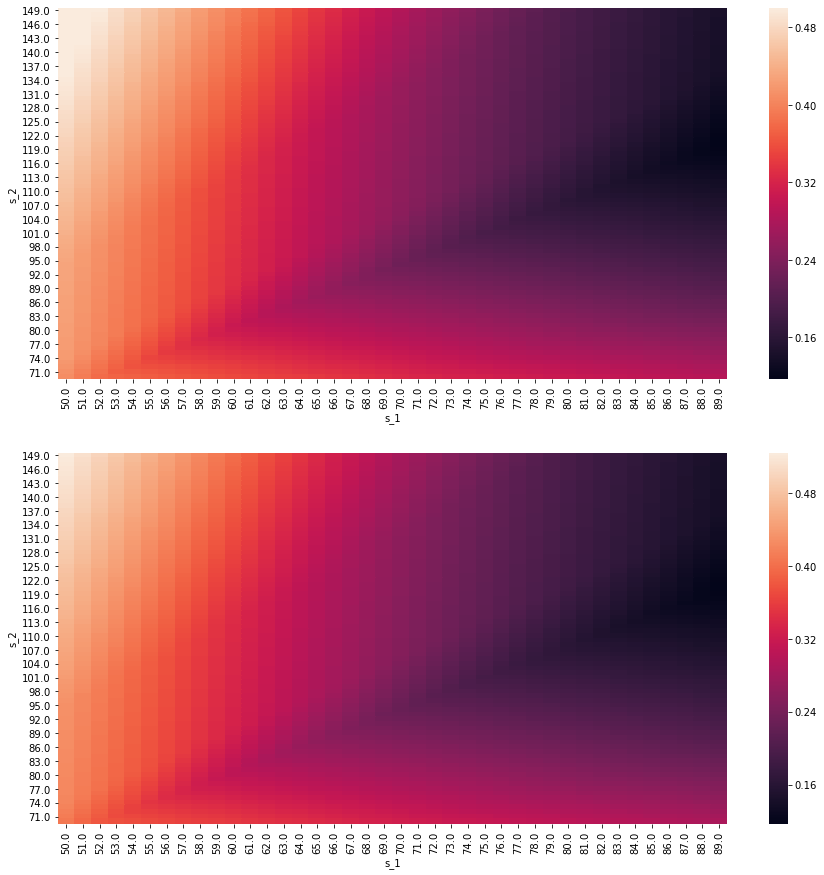

In [41]:
df = generate_policy_heatmap("/data/localhost/taufiq/model-wd-2/model-state-20-20-final")

In [4]:
def generate_true_policy_heatmap():
    df = pd.DataFrame()
    for i in range(50,90):
        for j in range(70,150):
            probs = gsm.physicians_policy(i, j, return_prob=True)
            df = df.append({'s_1': i, 's_2': j, 'prob-action': probs}, ignore_index=True)
    logit_probs = df.pivot("s_2", "s_1", "prob-action").sort_index(ascending=False)
    fig, (ax1, ax2) = plt.subplots(2,1, figsize=(15,15))
    sns.heatmap(logit_probs, vmax=0.50, ax=ax1)
    sns.heatmap(logit_probs, ax=ax2)
    plt.show()
    return df

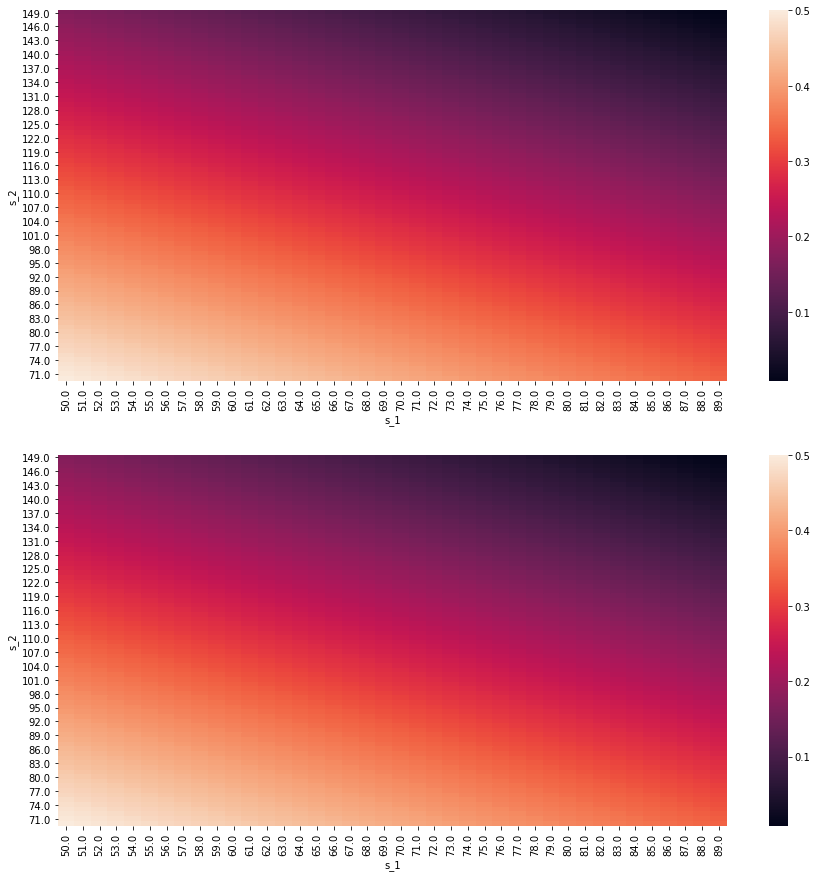

,prob-action,s_1,s_2
0,0.500000,50.0,70.0
1,0.495833,50.0,71.0
2,0.491667,50.0,72.0
3,0.487500,50.0,73.0
4,0.483333,50.0,74.0
...,...,...,...
3195,0.025000,89.0,145.0
3196,0.020833,89.0,146.0
3197,0.016667,89.0,147.0
3198,0.012500,89.0,148.0


In [5]:
generate_true_policy_heatmap()

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.ndimage.filters import gaussian_filter


def myplot(x, y, s, action, bins=1000, rng=None):
    if rng is None:
        if action == 0:
            plot_range = [[-20, 20], [-20, 20]]
        else:
            plot_range = [[0, 40], [0, 40]]
    else:
        plot_range = rng
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=bins, range=plot_range)
    heatmap = gaussian_filter(heatmap, sigma=s)

    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    return heatmap.T, extent

In [2]:
df_guide = pd.DataFrame()
for i in range(20000):
    state = gsm.S_t()
    s0_1, s0_2 = state.s_t[0], state.s_t[1]
    xt, ut = state.get_xt(), state.get_ut()
    action = gsm.physicians_policy(xt, ut)
    df_guide = df_guide.append({'s0_1': s0_1, 's0_2': s0_2, 'x0': xt, 'a0': action}, ignore_index=True)

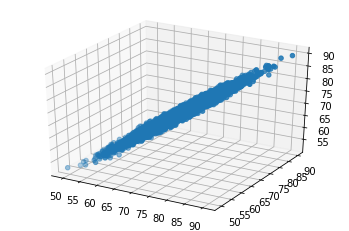

In [8]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
df0_transition = pd.DataFrame()
df1_transition = pd.DataFrame()
for index, row in df_guide.iterrows():
        s0_1, s0_2 = row['s0_1'], row['s0_2']
        action, x0 = row['a0'], row['x0']
        s0 = gsm.S_t([s0_1, s0_2])
        s0.next_state(action)
        x1 = s0.get_xt()
        s1 = s0.s_t
        if action == 0:
            df0_transition = df0_transition.append({'s0_1': s0_1, 's0_2': s0_2, 's1_1': s1.item(0), 's1_2': s1.item(1), 'x0': x0, 'x1':x1}, ignore_index=True)
        else:
            df1_transition = df1_transition.append({'s0_1': s0_1, 's0_2': s0_2, 's1_1': s1.item(0), 's1_2': s1.item(1), 'x0': x0, 'x1':x1}, ignore_index=True)

In [158]:
def posterior_plots(df0, df1, filename):
    model = SimpleModel(None, None, None, None)
    model.load_state_dict(torch.load(filename))
    model.eval()
    df_0 = pd.DataFrame()
    df_1 = pd.DataFrame()
    with torch.no_grad():
        for index, row in df0.iterrows():
            s0_1, s0_2 = row['s0_1'], row['s0_2']
            action, x0, x1 = 0, row['x0'], row['x1']
            s0_loc, s0_tril, s0_diag = model.s0_network(torch.tensor((x0, x1, action)).float())
            z = torch.zeros(1)
            scale_tril = torch.tensor([
                s0_diag[0], z,
                s0_tril[0], s0_diag[1]
            ]).view(2,2)
            s0 = dist.MultivariateNormal(loc=s0_loc, scale_tril=scale_tril).sample().numpy()
            s1_loc, s1_tril, s1_diag = model.s1_network(torch.tensor((s0.item(0), s0.item(1), action, x1)).float())
            scale_tril = torch.tensor([
                s1_diag[0], z,
                s1_tril[0], s1_diag[1]
            ]).view(2,2)
            s1 = dist.MultivariateNormal(loc=s1_loc, scale_tril=scale_tril).sample().numpy()
            df_0 = df_0.append({'s0_1': s0.item(0), 's0_2': s0.item(1), 's1_1': s1.item(0), 's1_2': s1.item(1), 'x0': x0, 'x1': x1}, ignore_index=True)
        for index, row in df1.iterrows():
            s0_1, s0_2 = row['s0_1'], row['s0_2']
            action, x0, x1 = 1, row['x0'], row['x1']
            s0_loc, s0_tril, s0_diag = model.s0_network(torch.tensor((x0, x1, action)).float())
            z = torch.zeros(1)
            scale_tril = torch.tensor([
                s0_diag[0], z,
                s0_tril[0], s0_diag[1]
            ]).view(2,2)
            s0 = dist.MultivariateNormal(loc=s0_loc, scale_tril=scale_tril).sample().numpy()
            s1_loc, s1_tril, s1_diag = model.s1_network(torch.tensor((s0.item(0), s0.item(1), action, x1)).float())
            scale_tril = torch.tensor([
                s1_diag[0], z,
                s1_tril[0], s1_diag[1]
            ]).view(2,2)
            s1 = dist.MultivariateNormal(loc=s1_loc, scale_tril=scale_tril).sample().numpy()
            df_1 = df_1.append({'s0_1': s0.item(0), 's0_2': s0.item(1), 's1_1': s1.item(0), 's1_2': s1.item(1), 'x0': x0, 'x1': x1}, ignore_index=True)
    return df_0, df_1

In [187]:
model_name = "model-learn-policy-posterior-wd_2.0-lr_0.001"
df0, df1 = posterior_plots(df0_transition, df1_transition, f"/data/localhost/taufiq/{model_name}/model-state-20-20-final")

In [188]:
%matplotlib notebook

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d    
def plot_posterior(df0, df1, component=1, t=0):
    global df0_transition, df1_transition
    fig = plt.figure(figsize=(9,4))
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    ax1 = fig.add_subplot(1, 2, 2, projection='3d')
    ax.scatter(df0['x0'], df0['x1'], df0[f's{t}_{component}'], marker='^')
    ax.scatter(df1['x0'], df1['x1'], df1[f's{t}_{component}'])
    ax1.scatter(df0_transition['x0'], df0_transition['x1'], df0_transition[f's{t}_{component}'], marker='^')
    ax1.scatter(df1_transition['x0'], df1_transition['x1'], df1_transition[f's{t}_{component}'])
    plt.legend(['$a_{0}=0$', '$a_{0}=1$'])
    ax.set_xlabel('$x_0$')
    ax.set_ylabel('$x_1$')
    ax.set_zlabel(f'$\hat{{S}}_{{{t},{component}}}$')
    ax1.set_xlabel('$x_0$')
    ax1.set_ylabel('$x_1$')
    ax1.set_zlabel(f'$S_{{{t},{component}}}$')
    plt.show()

<IPython.core.display.Javascript object>


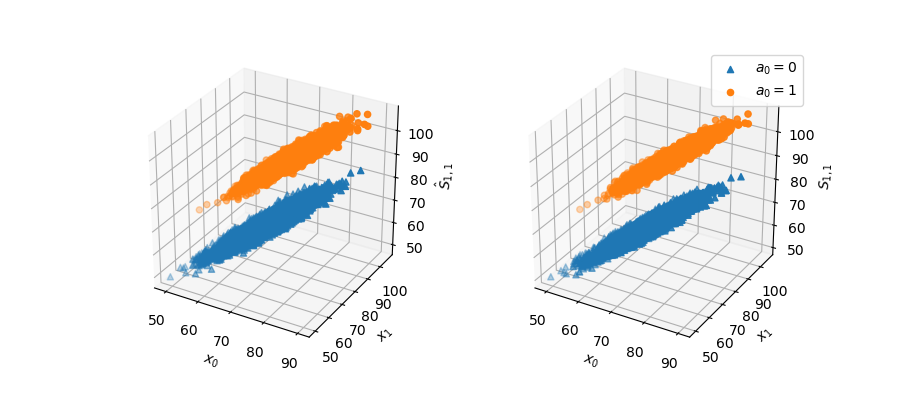

In [190]:
plot_posterior(df0, df1, component=1, t=1)

In [186]:
def generate_initial_state_heatmap(filename):
    model = SimpleModel(None, None, None, None)
    model.load_state_dict(torch.load(filename))
    model.eval()
    with torch.no_grad():

tensor([0.1369, 0.1945])

In [178]:
generate_initial_state_heatmap("/data/localhost/taufiq/model-learn-policy-posterior-is-wd_2.0-lr_0.001/model-state-20-20-final")

<bound method Module.modules of SimpleModel(
  (policy): Policy(
    (hid1): Linear(in_features=2, out_features=8, bias=True)
    (hid2): Linear(in_features=8, out_features=8, bias=True)
    (outp): Linear(in_features=8, out_features=2, bias=True)
    (leakyRelu): LeakyReLU(negative_slope=0.01)
  )
  (s1_network): SNetwork(
    (hid1): Linear(in_features=4, out_features=8, bias=True)
    (hid2): Linear(in_features=8, out_features=8, bias=True)
    (hid_to_loc): Linear(in_features=8, out_features=2, bias=True)
    (hid_to_tril): Linear(in_features=8, out_features=1, bias=True)
    (hid_to_diag): Linear(in_features=8, out_features=2, bias=True)
    (leakyRelu): LeakyReLU(negative_slope=0.01)
  )
  (s0_network): SNetwork(
    (hid1): Linear(in_features=3, out_features=8, bias=True)
    (hid2): Linear(in_features=8, out_features=8, bias=True)
    (hid_to_loc): Linear(in_features=8, out_features=2, bias=True)
    (hid_to_tril): Linear(in_features=8, out_features=1, bias=True)
    (hid_to_di

In [92]:
def generate_simulator_heatmap(df, filename):
    model = SimpleModel()
    model.load_state_dict(torch.load(filename))
    model.eval()
    df = df[['s0_1', 's0_2', 'x0', 'a0']]
    df_0 = pd.DataFrame()
    df_1 = pd.DataFrame()
    with torch.no_grad():
        for index, row in df.iterrows():
            s0_1, s0_2 = row['s0_1'], row['s0_2']
            action, xt = row['a0'], row['x0']
            st_loc, st_tril, st_diag = model.st_network(torch.tensor((s0_1, s0_2, action, xt)).float())
            z = torch.zeros(1)
            scale_tril = torch.tensor([
                st_diag[0], z,
                st_tril[0], st_diag[1]
            ]).view(2,2)
            s1 = dist.MultivariateNormal(loc=st_loc, scale_tril=scale_tril).sample().numpy()
            if action == 0:
                df_0 = df_0.append({'s0_1': s0_1, 's0_2': s0_2, 's1_1': s1.item(0), 's1_2': s1.item(1)}, ignore_index=True)
            else:
                df_1 = df_1.append({'s0_1': s0_1, 's0_2': s0_2, 's1_1': s1.item(0), 's1_2': s1.item(1)}, ignore_index=True)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))
    img, extent = myplot(df_0['s1_1']-df_0['s0_1'], df_0['s1_2']-df_0['s0_2'], 16, 0)
    ax1.imshow(img, extent=extent, origin='lower', cmap=cm.jet)
    ax1.set_title("$S_1 - S_0$ for $A_0 = 0$")
    img, extent = myplot(df_1['s1_1']-df_1['s0_1'], df_1['s1_2']-df_1['s0_2'], 16, 1)
    ax2.imshow(img, extent=extent, origin='lower', cmap=cm.jet)
    ax2.set_title("$S_1 - S_0$ for $A_0 = 1$")
    plt.show()

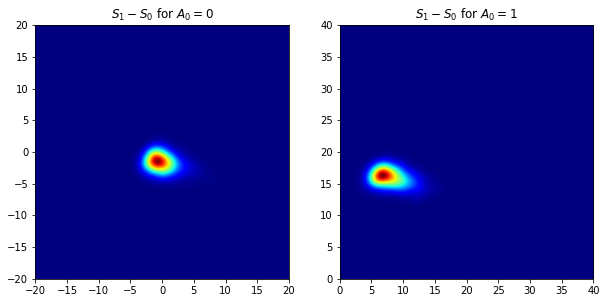

In [88]:
generate_simulator_heatmap(df_guide, "/Users/faaiz/simple-model/model-state-20-20")

In [22]:
def get_policy_accuracy(df, filename):
    model = SimpleModel()
    model.load_state_dict(torch.load(filename))
    model.eval()
    acc = 0
    with torch.no_grad():
        for index, row in df.iterrows():
            s0_1, s0_2 = row['s0_1'], row['s0_2']
            action, xt = row['a0'], row['x0']
            pred_action = dist.Categorical(logits=model.policy(torch.tensor((s0_1, s0_2)).float())).sample().numpy().item(0)
            acc += (pred_action == action)
    return acc/len(df)*100

In [36]:
get_policy_accuracy(df_guide, "/data/localhost/taufiq/model-run-weight-decay/model-state-20-20-final")

64.33

In [4]:
def combined_simulator_heatmap(df, filename):
    model = SimpleModel()
    model.load_state_dict(torch.load(filename))
    model.eval()
    df = df[['s0_1', 's0_2', 'x0', 'a0']]
    df_transition = pd.DataFrame()
    with torch.no_grad():
        for index, row in df.iterrows():
            s0_1, s0_2 = row['s0_1'], row['s0_2']
            action, xt = row['a0'], row['x0']
            st_loc, st_tril, st_diag = model.st_network(torch.tensor((s0_1, s0_2, action, xt)).float())
            z = torch.zeros(1)
            scale_tril = torch.tensor([
                st_diag[0], z,
                st_tril[0], st_diag[1]
            ]).view(2,2)
            s1 = dist.MultivariateNormal(loc=st_loc, scale_tril=scale_tril).sample().numpy()
            df_transition = df_transition.append({'s0_1': s0_1, 's0_2': s0_2, 's1_1': s1.item(0), 's1_2': s1.item(1)}, ignore_index=True)
    fig, ax = plt.subplots(1, 1, figsize=(10,10))
    img, extent = myplot(df_transition['s1_1']-df_transition['s0_1'], df_transition['s1_2']-df_transition['s0_2'], 4, action=None, rng=[[-30,30],[-30,30]])
    ax.imshow(img, extent=extent, origin='lower', cmap=cm.jet)
    ax.set_title("$S_1 - S_0$")
    ax.set_xlabel("$S_{0,1}$")
    ax.set_ylabel("$S_{0,2}$")
    plt.show()

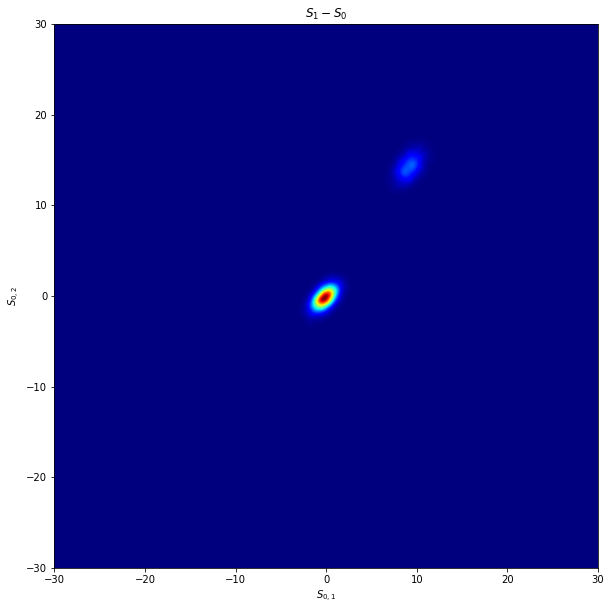

In [34]:
combined_simulator_heatmap(df_guide, "/data/localhost/taufiq/model-run-weight-decay/model-state-20-20-final")

In [39]:
def all_combined_simulator_heatmaps(df):
    x_vals = [5, 10, 15, 20, 25, 30, 35]
    fig, axs = plt.subplots(len(x_vals), len(x_vals), figsize=(15,15))
    for i in range(len(x_vals)):
        for j in range(len(x_vals)):
            filename = f"/data/localhost/taufiq/model-wd-2/model-state-{x_vals[i]}-{x_vals[j]}-final"
            model = SimpleModel()
            model.load_state_dict(torch.load(filename))
            model.eval()
            df = df[['s0_1', 's0_2', 'x0', 'a0']]
            df_transition = pd.DataFrame()
            with torch.no_grad():
                for index, row in df.iterrows():
                    s0_1, s0_2 = row['s0_1'], row['s0_2']
                    action, xt = row['a0'], row['x0']
                    st_loc, st_tril, st_diag = model.st_network(torch.tensor((s0_1, s0_2, action, xt)).float())
                    z = torch.zeros(1)
                    scale_tril = torch.tensor([
                        st_diag[0], z,
                        st_tril[0], st_diag[1]
                    ]).view(2,2)
                    s1 = dist.MultivariateNormal(loc=st_loc, scale_tril=scale_tril).sample().numpy()
                    df_transition = df_transition.append({'s0_1': s0_1, 's0_2': s0_2, 's1_1': s1.item(0), 's1_2': s1.item(1)}, ignore_index=True)
            img, extent = myplot(df_transition['s1_1']-df_transition['s0_1'], df_transition['s1_2']-df_transition['s0_2'], 4, action=None, rng=[[-30,30],[-30,30]])
            axs[j][i].imshow(img, extent=extent, origin='lower', cmap=cm.jet)
            axs[j][i].set_title(f"$g({x_vals[i]},{x_vals[j]})$")
            axs[j][i].set_xticks([])
            axs[j][i].set_yticks([])
    plt.show()

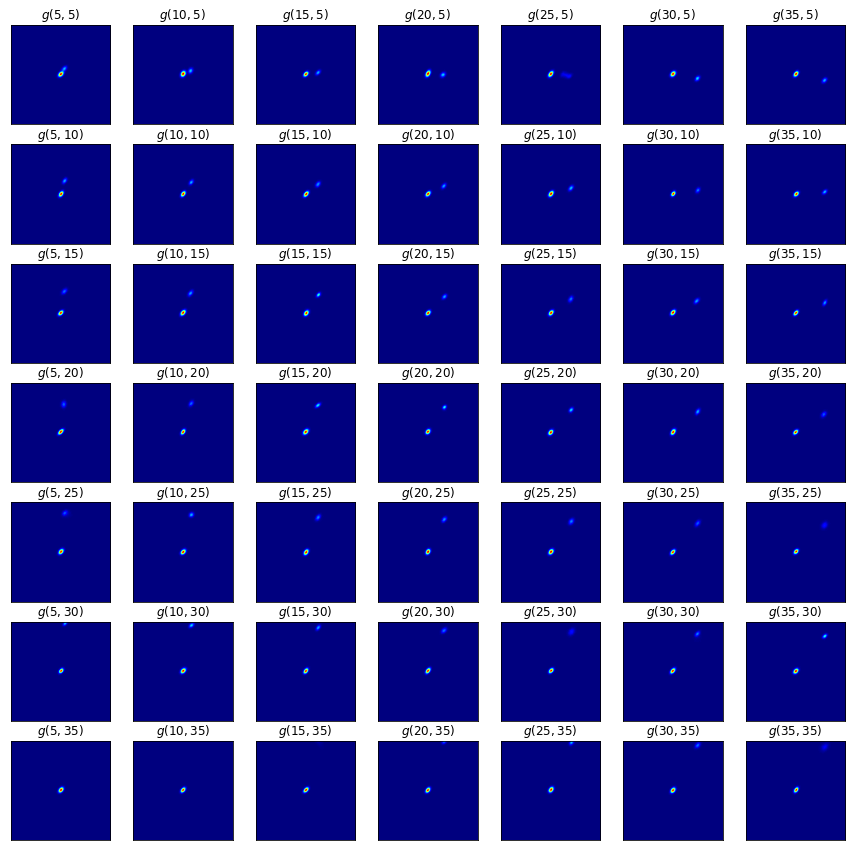

In [40]:
all_combined_simulator_heatmaps(df_guide)

In [14]:
def generate_true_model_heatmap(df):
    df = df[['s0_1', 's0_2', 'x0', 'a0']]
    df_transition = pd.DataFrame()
    for index, row in df.iterrows():
        s0_1, s0_2 = row['s0_1'], row['s0_2']
        action, xt = row['a0'], row['x0']
        s0 = gsm.S_t([s0_1, s0_2])
        s0.next_state(action)
        s1 = s0.s_t
        df_transition = df_transition.append({'s0_1': s0_1, 's0_2': s0_2, 's1_1': s1.item(0), 's1_2': s1.item(1)}, ignore_index=True)
    ig, ax = plt.subplots(1, 1, figsize=(10,10))
    img, extent = myplot(df_transition['s1_1']-df_transition['s0_1'], df_transition['s1_2']-df_transition['s0_2'], 4, action=None, rng=[[-30,30],[-30,30]])
    ax.imshow(img, extent=extent, origin='lower', cmap=cm.jet)
    ax.set_title("$S_1 - S_0$ for true model")
    ax.set_xlabel("$S_{0,1}$")
    ax.set_ylabel("$S_{0,2}$")
    plt.show()

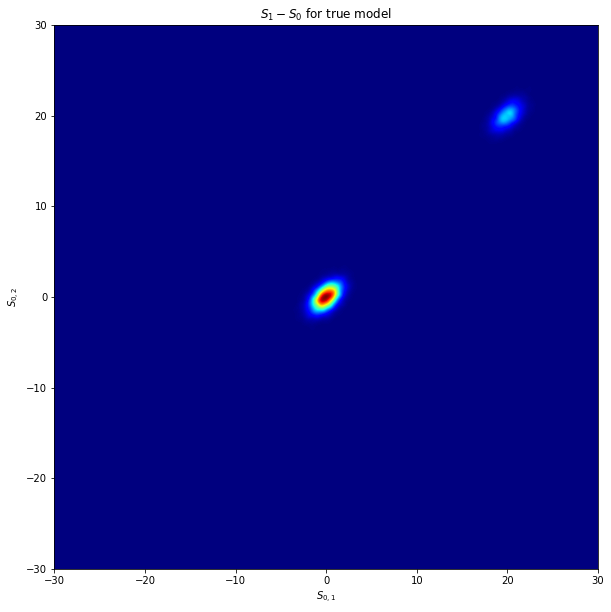

In [15]:
generate_true_model_heatmap(df_guide)